In [2]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import utils.visualisations
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms

import utils.metrics
import utils.model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


Load the dataset

In [12]:
class VOCTransform(object):
    """Converts area around object boundaries to background. (It is a special class by default)"""

    def __call__(self, labels):
        labels = (labels * 255).squeeze(0).to(torch.long)
        labels[labels == 255] = 0
        return labels

from datasets.transforms import AddGaussianNoise

transforms_normalized = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize( # dont use normalization if you want to draw the data
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

target_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    VOCTransform()
])


data_train = torchvision.datasets.VOCSegmentation(
    root="VOC", 
    # download=True, # Comment this out after the first time
    image_set="train", 
    transform=transforms_normalized, 
    target_transform=target_transforms)
data_loader_train = torch.utils.data.DataLoader(data_train,
                                          batch_size=16,
                                          shuffle=False)



data_test = torchvision.datasets.VOCSegmentation(
    root="VOC",
    #  download=True, 
     image_set="val", 
     transform=transforms_normalized,
      target_transform=target_transforms)
data_loader_test = torch.utils.data.DataLoader(data_test,
                                          batch_size=16,
                                          shuffle=False)

dataset_sizes = {"train": len(data_train), "val": len(data_test)}
data_loaders = {"train": data_loader_train, "val": data_loader_test}

Define function for drawing ground truth segmentations

In [10]:
VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "dining table",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]

def decode_segmap(image, nc=21):
    label_colors = np.array([(0, 0, 0),  # 0=background
                             # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
                             (128, 0, 0), (0, 128, 0), (128, 128,
                                                        0), (0, 0, 128), (128, 0, 128),
                             # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
                             (0, 128, 128), (128, 128, 128), (64,
                                                              0, 0), (192, 0, 0), (64, 128, 0),
                             # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
                             (192, 128, 0), (64, 0, 128), (192, 0,
                                                           128), (64, 128, 128), (192, 128, 128),
                             # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
                             (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128), (128, 128, 128)])
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb

Draw examples of the dataset

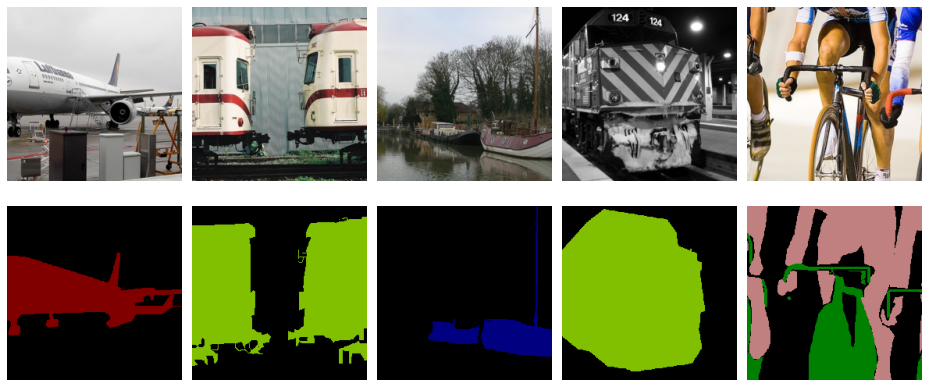

In [13]:
num = 5
fig, axs = plt.subplots(2, num, figsize=(13,6), squeeze=False)
for i in range(num):
    axs[0][i].imshow(data_test[i][0].permute((1,2,0)))
    axs[0][i].axis("off")
    axs[1][i].imshow(decode_segmap(data_test[i][1]))
    axs[1][i].axis("off")
plt.tight_layout()
# plt.savefig("figures/voc-segmentation-examples-noise0.2.pdf")

Load the models

In [14]:
# Standard model
model = torch.load("checkpoints/deeplab_resnet_finetune_no_dropout.pt", map_location=device).to(device)

# Dropout model
# model_dropout = torch.load("checkpoints/deeplab_resnet_finetune.pt").to(device)

Validate the models.

In [ ]:
from tqdm import tqdm
from typing import OrderedDict
import torch.nn.functional as F




def run_validation(model, data_loader, test_progress: utils.metrics.Progress, device, mc_dropout_iters=0):
    softmax = nn.Softmax(dim=1)
    progress_bar = tqdm(data_loader)
    count = 0
    running_corrects = 0
    model = model.to(device)
    softmax = torch.nn.Softmax(dim=1)
    for inputs, labels in progress_bar:
        inputs = inputs.to(device)
        count += labels.numel()
        model.eval()
        with torch.no_grad():
            logits = model(inputs)
        if isinstance(logits, OrderedDict):
            logits = logits["out"]    
        logits = logits.cpu()
        probs = softmax(logits)
        max_probs, preds = torch.max(probs, 1)
        running_corrects += np.count_nonzero(preds == labels.squeeze(1))
        if mc_dropout_iters > 0:
            mc_means, mc_vars = utils.mc_dropout.mc_dropout(
                model, inputs, logits.shape[1:], T=mc_dropout_iters)
            mc_max_probs, mc_predictions = mc_means.max(axis=1)
            test_progress.dropout_predictions = np.append(
                test_progress.dropout_predictions, mc_predictions)
            test_progress.dropout_max_probs = np.append(test_progress.dropout_max_probs, mc_max_probs)
        test_progress.update(preds, labels, probs, logits)
        progress_bar.set_description(
            f"Avg. acc.: {100*running_corrects/count:.2f}")

    test_progress.predictions = np.concatenate(test_progress.predictions)
    test_progress.logits = np.concatenate(test_progress.logits)
    test_progress.probs = np.concatenate(test_progress.probs)
    return test_progress

# Standard model
progress = run_validation(
    model, data_loader_test, utils.metrics.Progress(), device, mc_dropout_iters=0)  

# Dropout model
# progress_dropout = run_validation(
#     model_dropout, data_loader_test, utils.metrics.Progress(), device, mc_dropout_iters=20)  

Draw calibration graphs of the models

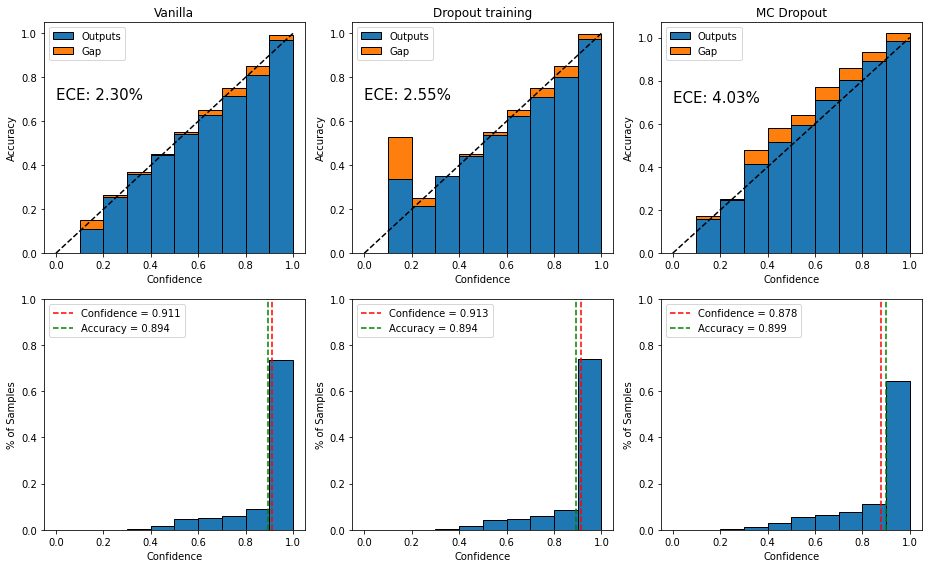

In [19]:
utils.visualisations.calibration_graph([
        # Standard model
        ("Vanilla", progress.max_probs, np.argsort(progress.max_probs), progress.predictions.ravel()),
        # Dropout model
        # ("Dropout training", progress_dropout.max_probs, np.argsort(progress.max_probs), progress.predictions.ravel()),
        # ("MC Dropout", progress_dropout.dropout_max_probs, np.argsort(progress.dropout_max_probs), progress.dropout_predictions.ravel()),
    ],
    progress.labels,
    figsize=(13,8)
    )

# plt.savefig("figures/voc_segmentation.pdf")

Validate the models on the shifted dataset

In [29]:
curves = {
    "Vanilla": utils.metrics.model_metrics(),
    "Dropout training": utils.metrics.model_metrics(),
    "MC Dropout":utils.metrics.model_metrics(),
}

from datasets.transforms import AddGaussianNoise


for s in np.arange(0, 0.6, 0.05):

    transforms_normalized = torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        AddGaussianNoise(std=s),
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    target_transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        VOCTransform()
    ])





    data_test = torchvision.datasets.VOCSegmentation(
        root="VOC", download=True, image_set="val", transform=transforms_normalized, target_transform=target_transforms)
    data_loader_test = torch.utils.data.DataLoader(data_test,
                                            batch_size=16,
                                            shuffle=False)


    print(f"Strength: {s}")

    # Standard model
    progress = run_validation(
        model, data_loader_test, utils.metrics.Progress(), device, mc_dropout_iters=0)

    # Dropout model
    # progress_dropout = run_validation(
    #     model_dropout, data_loader_test, utils.metrics.Progress(), device, mc_dropout_iters=20)



    bins = np.linspace(0.05, 0.95, num=10)
    labels = progress.labels.ravel()
    labels_2d = torch.as_tensor(progress.labels.reshape(progress.predictions.shape)).to(torch.long)

    # Standard model
    max_probs = progress.max_probs.ravel()
    utils.metrics.update_model_metrics(None, max_probs, progress.predictions.ravel(), labels, bins, curves["Vanilla"], s)
    preds = torch.as_tensor(progress.predictions).to(torch.long)
    curves["Vanilla"].ious.append(utils.metrics.iou(preds, labels_2d, num_classes=21))
    curves["Vanilla"].mious.append(utils.metrics.mean_class_iou(preds, labels_2d, num_classes=21))

    # Dropout model
    # max_probs = progress_dropout.max_probs.ravel()
    # utils.metrics.update_model_metrics(None, max_probs, progress_dropout.predictions.ravel(), labels, bins, curves["Dropout training"], s)
    # preds = torch.as_tensor(progress_dropout.predictions).to(torch.long)
    # curves["Dropout training"].ious.append(utils.metrics.iou(preds, labels_2d, num_classes=21))
    # curves["Dropout training"].mious.append(utils.metrics.mean_class_iou(preds, labels_2d, num_classes=21))


    # max_probs = progress_dropout.dropout_max_probs.ravel()
    # utils.metrics.update_model_metrics(None, max_probs, progress_dropout.dropout_predictions, labels, bins, curves["MC Dropout"], s)
    # preds = torch.as_tensor(progress_dropout.dropout_predictions).reshape(progress_dropout.predictions.shape).to(torch.long)
    # curves["MC Dropout"].ious.append(utils.metrics.iou(preds, labels_2d, num_classes=21))
    # curves["MC Dropout"].mious.append(utils.metrics.mean_class_iou(preds, labels_2d, num_classes=21))

    del progress
    # del progress_dropout


Using downloaded and verified file: VOC/VOCtrainval_11-May-2012.tar
Extracting VOC/VOCtrainval_11-May-2012.tar to VOC
Strength: 0.0


Avg. acc.: 89.36: 100%|██████████| 91/91 [01:05<00:00,  1.38it/s]


Using downloaded and verified file: VOC/VOCtrainval_11-May-2012.tar
Extracting VOC/VOCtrainval_11-May-2012.tar to VOC
Strength: 0.05


Avg. acc.: 87.68: 100%|██████████| 91/91 [01:05<00:00,  1.39it/s]


Using downloaded and verified file: VOC/VOCtrainval_11-May-2012.tar
Extracting VOC/VOCtrainval_11-May-2012.tar to VOC
Strength: 0.1


Avg. acc.: 84.94: 100%|██████████| 91/91 [01:05<00:00,  1.39it/s]


Using downloaded and verified file: VOC/VOCtrainval_11-May-2012.tar
Extracting VOC/VOCtrainval_11-May-2012.tar to VOC
Strength: 0.15000000000000002


Avg. acc.: 81.16: 100%|██████████| 91/91 [01:06<00:00,  1.38it/s]


Using downloaded and verified file: VOC/VOCtrainval_11-May-2012.tar
Extracting VOC/VOCtrainval_11-May-2012.tar to VOC
Strength: 0.2


Avg. acc.: 76.89: 100%|██████████| 91/91 [01:05<00:00,  1.39it/s]


Using downloaded and verified file: VOC/VOCtrainval_11-May-2012.tar
Extracting VOC/VOCtrainval_11-May-2012.tar to VOC
Strength: 0.25


Avg. acc.: 73.61: 100%|██████████| 91/91 [01:05<00:00,  1.39it/s]


Using downloaded and verified file: VOC/VOCtrainval_11-May-2012.tar
Extracting VOC/VOCtrainval_11-May-2012.tar to VOC
Strength: 0.30000000000000004


Avg. acc.: 70.06: 100%|██████████| 91/91 [01:05<00:00,  1.38it/s]


Using downloaded and verified file: VOC/VOCtrainval_11-May-2012.tar
Extracting VOC/VOCtrainval_11-May-2012.tar to VOC
Strength: 0.35000000000000003


Avg. acc.: 67.69: 100%|██████████| 91/91 [01:05<00:00,  1.39it/s]


Using downloaded and verified file: VOC/VOCtrainval_11-May-2012.tar
Extracting VOC/VOCtrainval_11-May-2012.tar to VOC
Strength: 0.4


Avg. acc.: 65.82: 100%|██████████| 91/91 [01:05<00:00,  1.38it/s]


Using downloaded and verified file: VOC/VOCtrainval_11-May-2012.tar
Extracting VOC/VOCtrainval_11-May-2012.tar to VOC
Strength: 0.45


Avg. acc.: 64.62: 100%|██████████| 91/91 [01:05<00:00,  1.39it/s]


Using downloaded and verified file: VOC/VOCtrainval_11-May-2012.tar
Extracting VOC/VOCtrainval_11-May-2012.tar to VOC
Strength: 0.5


Avg. acc.: 63.64: 100%|██████████| 91/91 [01:05<00:00,  1.39it/s]


Using downloaded and verified file: VOC/VOCtrainval_11-May-2012.tar
Extracting VOC/VOCtrainval_11-May-2012.tar to VOC
Strength: 0.55


Avg. acc.: 63.41: 100%|██████████| 91/91 [01:05<00:00,  1.39it/s]


Save the results of evaluation on shifted datasets

In [9]:
import pickle
with open("experiments/voc-segmentation-noise-dropout.pickle", "wb") as f:
    pickle.dump(curves,f)

or Load previous results

In [4]:
import pickle
with open("experiments/voc-segmentation-noise-dropout.pickle", "rb") as f:
    curves = pickle.load(f)

Print latex table of results on the standard dataset

In [40]:
import pandas as pd
df = pd.DataFrame()

for label, prog in curves.items():
    row = {"label":label}

    for name,val in vars(prog).items():
        if len(val)>0:
            row[name] = val[0].item() if isinstance(val[0], torch.Tensor) else val[0]
    df=df.append(row,ignore_index=True)
df=df.drop(["strengths"], axis=1)
print(df.to_latex(float_format="%.3f"))

\begin{tabular}{llrrrrrrr}
\toprule
{} &             label &   acc &   ece &  confs &  auroc &  aupr &  ious &  mious \\
\midrule
0 &           Vanilla & 0.894 & 2.299 &  0.911 &  0.878 & 0.983 & 0.692 &  0.647 \\
1 &  Dropout training & 0.894 & 2.546 &  0.913 &  0.882 & 0.984 & 0.698 &  0.652 \\
2 &        MC Dropout & 0.899 & 4.038 &  0.878 &  0.883 & 0.985 & 0.699 &  0.644 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_1484856/2829502520.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(row,ignore_index=True)
/tmp/ipykernel_1484856/2829502520.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(row,ignore_index=True)
/tmp/ipykernel_1484856/2829502520.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(row,ignore_index=True)
/tmp/ipykernel_1484856/2829502520.py:12: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_late

Draw a figure of metrics changing with strength of shift

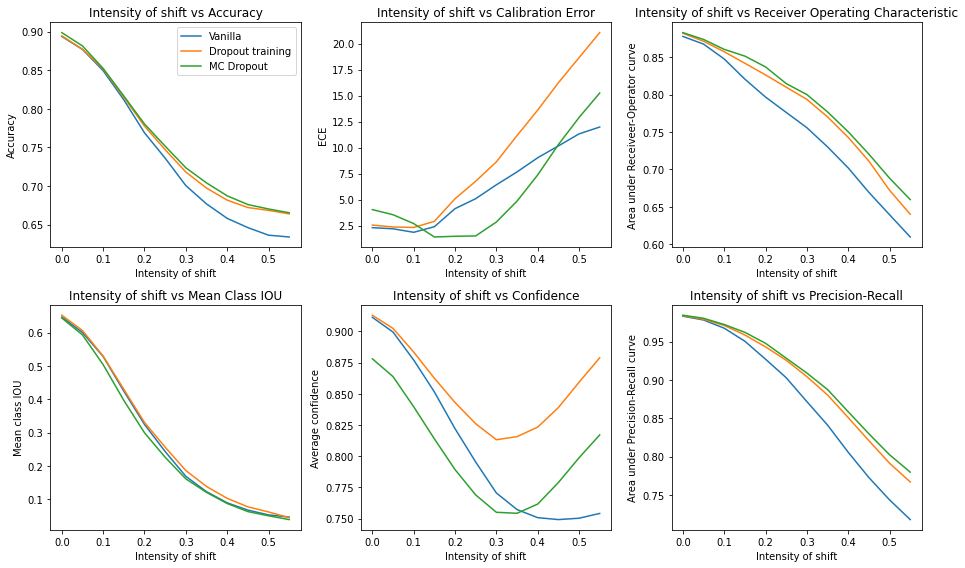

In [23]:
fig, axs = plt.subplots(2, 3, figsize=(13, 8))
for name, m in curves.items():
    ax = axs[0][0]
    ax.plot(m.strengths, m.acc, label=name)
    ax.set_title("Intensity of shift vs Accuracy")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("Accuracy")

    ax = axs[1][0]
    ax.plot(m.strengths, m.mious, label=name)
    ax.set_title("Intensity of shift vs Mean Class IOU")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("Mean class IOU")

    ax = axs[0][1]
    ax.plot(m.strengths, m.ece, label=name)
    ax.set_title("Intensity of shift vs Calibration Error")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("ECE")

    ax = axs[1][1]
    ax.plot(m.strengths, m.confs, label=name)
    ax.set_title("Intensity of shift vs Confidence")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("Average confidence")

    ax = axs[0][2]
    ax.plot(m.strengths, m.auroc, label=name)
    ax.set_title("Intensity of shift vs Receiver Operating Characteristic")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("Area under Receiveer-Operator curve")

    ax = axs[1][2]
    ax.plot(m.strengths, m.aupr, label=name)
    ax.set_title("Intensity of shift vs Precision-Recall")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("Area under Precision-Recall curve")
handles, labels = ax.get_legend_handles_labels()
axs[0][0].legend(handles, labels)
fig.tight_layout()

# plt.savefig("figures/voc-segmentation-gaussian-noise.pdf")